In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
from collections import defaultdict

import biojepa_ac_model as model
from biojepa_ac_model import BioJepaConfig
from bio_dataloader import TrainingLoader

## BioJEPA Model load

In [2]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cuda


In [3]:
torch.manual_seed(1337)
random.seed(1337)

In [4]:
batch_size = 256
n_embd = 256
training_file_chunk = 25000
n_heads = 4
n_layers = 6
n_genes = 5000

In [5]:
data_dir = Path('/home/ubuntu')
train_dir = data_dir / 'training'
checkpoint_dir = data_dir / 'checkpoint'
pert_dir = data_dir / 'pert_embd'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

In [6]:
print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)


In [7]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

**Load Checkpoint**

In [8]:
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_63539_final.pt'
with torch.serialization.safe_globals([BioJepaConfig]):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

**Freeze Model**

In [9]:
model.freeze_encoders()
model.eval()
for param in model.parameters():
    param.requires_grad = False

## Build Decoder

In [10]:
def init_weights_robust(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        if isinstance(module, nn.Embedding):
            fan_in = module.embedding_dim
        else:
            fan_in = module.weight.size(1)
        std = 1.0 / math.sqrt(fan_in) if fan_in > 0 else 0.02
        nn.init.trunc_normal_(module.weight, mean=0.0, std=std, a=-2*std, b=2*std)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)

@dataclass
class BenchmarkDecoderConfig:
    embed_dim: int = 256
    
class BenchmarkDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.head = nn.Linear(config.embed_dim, 1)

        self.apply(init_weights_robust)
        
    def forward(self, latents):

        gene_preds = self.head(latents)        
        gene_preds = gene_preds.squeeze(-1)
        
        return gene_preds

### Data Loader

In [11]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 3 shards for split train
loading /home/ubuntu/training/train/shard_k562e_train_0000.npz
found 1 shards for split val
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz


## Training Decoder

### Training Config/Setup

In [12]:
lr_decoder = 1e-3
epochs = 20

**Initialize Decoder** 

In [13]:
config = BenchmarkDecoderConfig(
    embed_dim= n_embd
)

decoder = BenchmarkDecoder(config).to(DEVICE)

**Optimizer**

In [14]:
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr_decoder)

**Training Lenght**

In [15]:
train_total_examples = 101682

In [16]:
steps_per_epoch = train_total_examples // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(397, 7940)

**Scheduler**

In [17]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr_decoder, total_steps=max_steps, pct_start=0.05
)

### Training Loop

In [18]:
lossi = []
step = 0
total_epoch_loss = 0

In [19]:
decoder.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 250 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 25
            for i in range(val_loss_steps):
                cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()
                B, N = cont_x.shape

                # run BioJEPA
                z_context = model.student(cont_x, cont_tot, mask_idx=None)
                target_indices = torch.arange(N, device=DEVICE).expand(B, N)
                z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)

                # run new decoder
                pred_delta = decoder(z_pred_mu) - decoder(z_context)
                real_delta = case_x - cont_x

                loss = F.mse_loss(pred_delta, real_delta)
                val_loss_accum += loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        decoder.train()

    # periodically save checkpoint
    if step > 0 and  (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}.pt')

    # actual training

    cont_x, cont_tot, case_x, case_tot, act_id = train_loader.next_batch()
    B, N = cont_x.shape

    # run frozen BioJEPA
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)

    optimizer.zero_grad()

    # run decoder
    pred_case = decoder(z_pred_mu)
    pred_control = decoder(z_context)

    pred_delta = pred_case - pred_control
    real_delta = case_x - cont_x

    # loss
    loss = F.mse_loss(pred_delta, real_delta)
    loss.backward()

    optimizer.step()
    scheduler.step()

    # loss caching
    lossi.append(loss.item())
    total_epoch_loss += loss.item()

    if step % 50 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}_final.pt')
        

val loss: 2.1570
Step 0 | Loss: 2.15060 | LR: 4.00e-05
Step 25 | Loss: 2.06919 | LR: 5.02e-05
Step 50 | Loss: 1.96171 | LR: 7.88e-05
Step 75 | Loss: 1.77763 | LR: 1.25e-04
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz
val loss: 1.5893
Step 100 | Loss: 1.60539 | LR: 1.86e-04
Step 125 | Loss: 1.39697 | LR: 2.60e-04
Step 150 | Loss: 1.21853 | LR: 3.45e-04
Step 175 | Loss: 1.07882 | LR: 4.37e-04
loading /home/ubuntu/training/train/shard_k562e_train_0001.npz
val loss: 0.9383
Step 200 | Loss: 0.93448 | LR: 5.31e-04
Step 225 | Loss: 0.83324 | LR: 6.26e-04
Step 250 | Loss: 0.73743 | LR: 7.16e-04
Step 275 | Loss: 0.69897 | LR: 7.98e-04
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz
val loss: 0.6361
Step 300 | Loss: 0.64309 | LR: 8.70e-04
Step 325 | Loss: 0.59780 | LR: 9.28e-04
Step 350 | Loss: 0.58052 | LR: 9.70e-04
Step 375 | Loss: 0.55654 | LR: 9.94e-04
loading /home/ubuntu/training/train/shard_k562e_train_0002.npz
=== Step 396 Done. Avg Loss: 1.13246 ===
loading /hom

**Training Loss Plot**

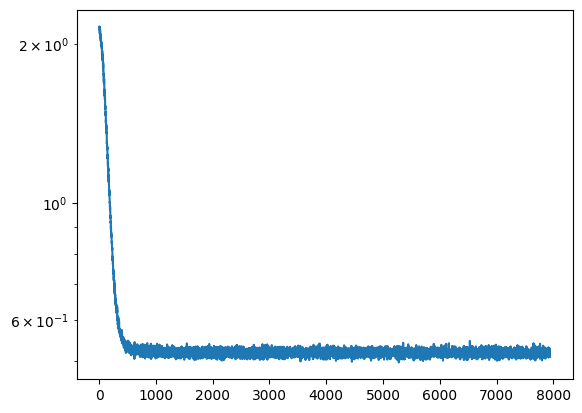

In [20]:
plt.plot(lossi)
plt.yscale('log')

## Trained Decoder Validation

In [21]:
import warnings
from scipy.stats import ConstantInputWarning

In [22]:
model.eval()
decoder.eval()

BenchmarkDecoder(
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
bulk_preds = defaultdict(list)      
bulk_reals = defaultdict(list)     
bulk_reals_delta = defaultdict(list)

val_r2_all = []
val_r2_top50 = []
val_correlations = []
val_mses = []

In [24]:
val_total_examples = 11044
val_steps_per_epoch = val_total_examples // batch_size
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)


found 1 shards for split val
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz


In [25]:
for step in tqdm(range(val_steps_per_epoch), desc='Benchmarking'):
    
    cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x

        pred_absolute = cont_x + pred_delta
    
    pred_delta_np = pred_delta.cpu().numpy()
    real_delta_np = real_delta.cpu().numpy()

    pred_abs_np = pred_absolute.cpu().numpy()
    real_abs_np = case_x.cpu().numpy()
    
    act_id_np = act_id.cpu().numpy().flatten()

    for i in range(B):
        p_delta = pred_delta_np[i]
        t_delta = real_delta_np[i]
        pid = act_id_np[i] 

        val_mses.append(np.mean((p_delta - t_delta)**2))

        top_20_idx = np.argsort(np.abs(t_delta))[-20:]
        p_top = p_delta[top_20_idx]
        t_top = t_delta[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            val_correlations.append(0.0 if np.isnan(corr) else corr)
        else:
            val_correlations.append(0.0)

        bulk_preds[pid].append(pred_abs_np[i])
        bulk_reals[pid].append(real_abs_np[i])
        bulk_reals_delta[pid].append(real_delta_np[i])

Benchmarking: 100%|██████████████████████████████████████████████████| 43/43 [00:33<00:00,  1.27it/s]


In [26]:
for pid in bulk_preds:
    p_mean = np.mean(np.stack(bulk_preds[pid]), axis=0)
    t_mean = np.mean(np.stack(bulk_reals[pid]), axis=0)
    t_mean_delta = np.mean(np.stack(bulk_reals_delta[pid]), axis=0)

    if np.std(t_mean) > 1e-9:
        val_r2_all.append(r2_score(t_mean, p_mean))
    
    top_50_idx = np.argsort(np.abs(t_mean_delta))[-50:] 
    
    val_r2_top50.append(r2_score(t_mean[top_50_idx], p_mean[top_50_idx]))

In [27]:
val_mean_mse = np.mean(val_mses)
val_mean_corr = np.mean(val_correlations)
val_mean_r2_all = np.mean(val_r2_all)
val_median_r2_all = np.median(val_r2_all)
val_mean_r2_top50 = np.mean(val_r2_top50)
val_median_r2_top50 = np.median(val_r2_top50)

In [28]:
print(f'Global MSE: {val_mean_mse:.4f}')
print(f'Top-20 Pearson R: {val_mean_corr:.4f}')
print(f'R^2 (All Genes): Mean: {val_mean_r2_all:.4f}, Median: {val_median_r2_all:.4f}')
print(f'R^2 (Top 50 DEGs): Mean: {val_mean_r2_top50:.4f}, Median: {val_median_r2_top50:.4f}')

Global MSE: 0.5177
Top-20 Pearson R: 0.9212
R^2 (All Genes): Mean: 0.9030, Median: 0.9088
R^2 (Top 50 DEGs): Mean: 0.0832, Median: 0.1892


## Trained Decoder Evaluation

In [29]:
bulk_preds = defaultdict(list)
bulk_reals = defaultdict(list)
bulk_reals_delta = defaultdict(list)

test_r2_all = []
test_r2_top50 = []
test_correlations = []
test_mses = []

In [30]:
test_total_examples = 38829
test_loader = TrainingLoader(batch_size=batch_size, split='test', data_dir=train_dir, device=DEVICE)
test_steps_per_epoch = test_total_examples // batch_size


found 1 shards for split test
loading /home/ubuntu/training/test/shard_k562e_test_0000.npz


In [31]:
for step in tqdm(range(test_steps_per_epoch), desc='Benchmarking'):
    
    cont_x, cont_tot, case_x, case_tot, act_id = test_loader.next_batch()
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x

        pred_absolute = cont_x + pred_delta
    
    pred_delta_np = pred_delta.cpu().numpy()
    real_delta_np = real_delta.cpu().numpy()

    pred_abs_np = pred_absolute.cpu().numpy()
    real_abs_np = case_x.cpu().numpy()
    
    act_id_np = act_id.cpu().numpy().flatten()


    for i in range(B):
        p_delta = pred_delta_np[i]
        t_delta = real_delta_np[i]
        pid = act_id_np[i] 

        test_mses.append(np.mean((p_delta - t_delta)**2))

        top_20_idx = np.argsort(np.abs(t_delta))[-20:]
        p_top = p_delta[top_20_idx]
        t_top = t_delta[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            test_correlations.append(0.0 if np.isnan(corr) else corr)
        else:
            test_correlations.append(0.0)

        bulk_preds[pid].append(pred_abs_np[i])
        bulk_reals[pid].append(real_abs_np[i])
        bulk_reals_delta[pid].append(real_delta_np[i])

Benchmarking:  62%|██████████████████████████████▏                  | 93/151 [01:13<00:45,  1.27it/s]/tmp/ipykernel_24068/4001959697.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(p_top, t_top)
Benchmarking: 100%|████████████████████████████████████████████████| 151/151 [01:58<00:00,  1.27it/s]


In [32]:
for pid in bulk_preds:
    p_mean = np.mean(np.stack(bulk_preds[pid]), axis=0)
    t_mean = np.mean(np.stack(bulk_reals[pid]), axis=0)
    t_mean_delta = np.mean(np.stack(bulk_reals_delta[pid]), axis=0)

    if np.std(t_mean) > 1e-9:
        test_r2_all.append(r2_score(t_mean, p_mean))
    
    top_50_idx = np.argsort(np.abs(t_mean_delta))[-50:] 
    
    test_r2_top50.append(r2_score(t_mean[top_50_idx], p_mean[top_50_idx]))

In [33]:
test_mean_mse = np.mean(test_mses)
test_mean_corr = np.mean(test_correlations)
test_mean_r2_all = np.mean(test_r2_all)
test_median_r2_all = np.median(test_r2_all)
test_mean_r2_top50 = np.mean(test_r2_top50)
test_median_r2_top50 = np.median(test_r2_top50)

In [34]:
print(f'Global MSE: {test_mean_mse:.4f}')
print(f'Top-20 Pearson R: {test_mean_corr:.4f}')
print(f'R^2 (All Genes) - Mean: {test_mean_r2_all:.4f}, Median: {test_median_r2_all:.4f}')
print(f'R^2 (Top 50 DEGs) - Mean: {test_mean_r2_top50:.4f}, Median: {test_median_r2_top50:.4f}')

Global MSE: 0.5153
Top-20 Pearson R: 0.9209
R^2 (All Genes) - Mean: 0.9018, Median: 0.9103
R^2 (Top 50 DEGs) - Mean: 0.0602, Median: 0.2552


In [36]:
diff = np.abs(pred_absolute.cpu().numpy() - cont_x.cpu().numpy()).mean()
print(f"Average Predicted Shift magnitude: {diff:.4f}")

Average Predicted Shift magnitude: 0.5362


In [37]:
for i in top_50_idx:
    print(f'{i} | {p_mean[i]:.4f} | {t_mean[i]:.4f} |  {(p_mean[i] - t_mean[i]):.4f} | {((p_mean[i] - t_mean[i])/(t_mean[i])):.2f}')
    

2138 | 1.3062 | 1.6131 |  -0.3069 | -0.19
1011 | 1.1062 | 0.8533 |  0.2528 | 0.30
3705 | 0.9970 | 0.4258 |  0.5712 | 1.34
521 | 0.7017 | 1.0426 |  -0.3410 | -0.33
3053 | 1.4356 | 1.6548 |  -0.2191 | -0.13
2351 | 1.0921 | 0.6466 |  0.4455 | 0.69
4639 | 0.8800 | 1.2989 |  -0.4189 | -0.32
272 | 1.1252 | 1.0410 |  0.0842 | 0.08
636 | 1.0773 | 0.6310 |  0.4463 | 0.71
4546 | 0.5293 | 0.1574 |  0.3720 | 2.36
1793 | 0.7566 | 1.1037 |  -0.3471 | -0.31
1689 | 0.2826 | 0.9347 |  -0.6520 | -0.70
2858 | 0.9409 | 0.6639 |  0.2770 | 0.42
371 | 1.1604 | 1.5837 |  -0.4233 | -0.27
3694 | 0.6511 | 0.4115 |  0.2395 | 0.58
1863 | 0.7790 | 0.5561 |  0.2230 | 0.40
1290 | 1.2554 | 1.1750 |  0.0804 | 0.07
3809 | 0.2244 | 0.6317 |  -0.4073 | -0.64
2592 | 0.9586 | 1.3353 |  -0.3768 | -0.28
431 | 1.6719 | 1.2455 |  0.4264 | 0.34
1084 | 1.0640 | 0.7276 |  0.3364 | 0.46
2991 | 0.8690 | 0.2808 |  0.5882 | 2.09
4806 | 0.6816 | 0.3199 |  0.3617 | 1.13
1561 | 0.7661 | 0.4743 |  0.2918 | 0.62
1700 | 0.5421 | 1.1439 |  -